<a href="https://colab.research.google.com/github/debashisdotchatterjee/General_Polya_Counterexamples/blob/main/General_Polya_Counterexamples_Python_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simulation Part 1**

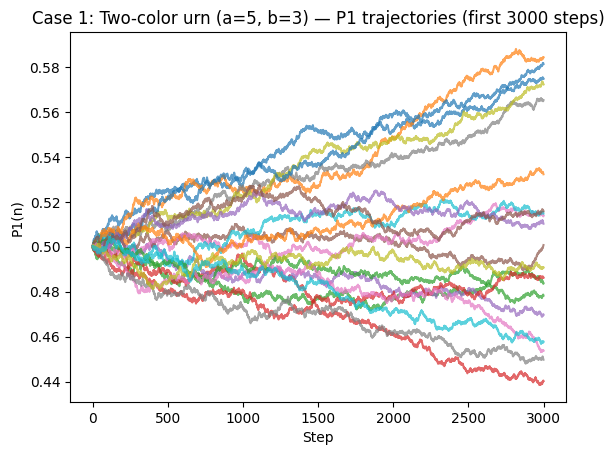

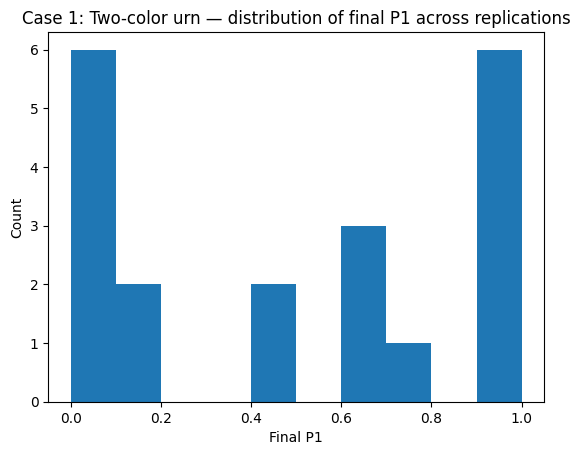

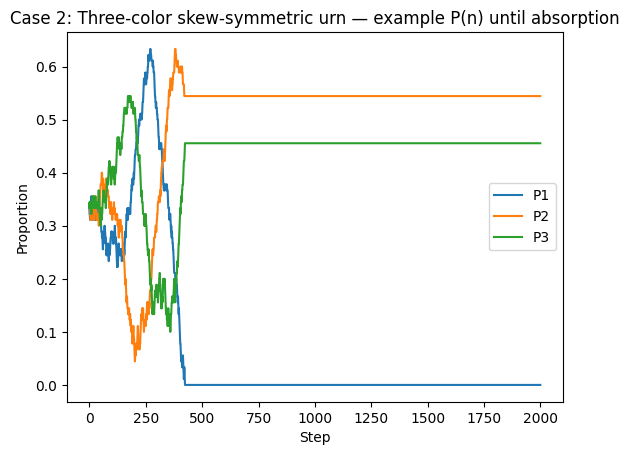

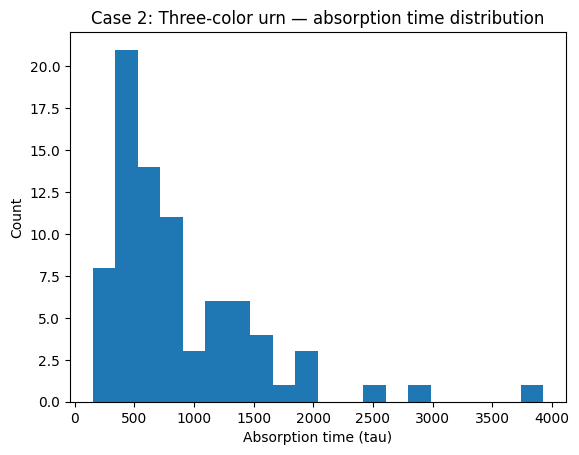

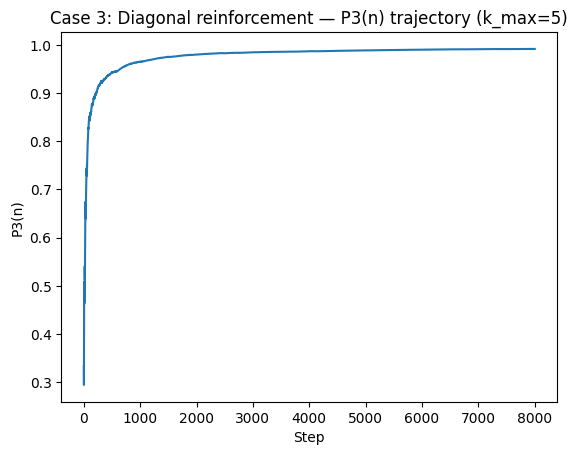

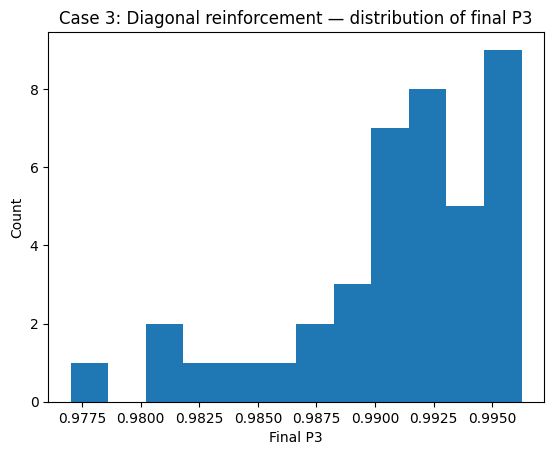

{'case1_fig1': 'polya_urn_verification/figs/case1_two_color_P1_trajectories.png',
 'case1_fig2': 'polya_urn_verification/figs/case1_two_color_final_P1_hist.png',
 'case1_csv': 'polya_urn_verification/csv/case1_two_color_summary.csv',
 'case2_fig1': 'polya_urn_verification/figs/case2_three_color_example_P.png',
 'case2_fig2': 'polya_urn_verification/figs/case2_three_color_tau_hist.png',
 'case2_csv': 'polya_urn_verification/csv/case2_three_color_summary.csv',
 'case3_fig1': 'polya_urn_verification/figs/case3_diag_P3_trajectory.png',
 'case3_fig2': 'polya_urn_verification/figs/case3_diag_final_P3_hist.png',
 'case3_csv': 'polya_urn_verification/csv/case3_diag_summary.csv',
 'base_dir': 'polya_urn_verification'}

In [7]:
# Simulation verification for Generalized Pólya urns (three cases)
# - Uses row convention: when color i is drawn, add row i of R to the composition X
# - Tenability: stop before any coordinate would become negative; then keep X constant
# - Produces figures and CSV summaries in a downloadable folder
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility of this notebook run
rng = np.random.default_rng(12345)

# Output folders
base_dir = "polya_urn_verification"
fig_dir = os.path.join(base_dir, "figs")
csv_dir = os.path.join(base_dir, "csv")
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

def simulate_urn(R, X0, n_steps=10000, tenable=True):
    """
    Row convention: draw color i with prob X_i / S, update X <- X + R[i,:].
    If tenable is True, stop before any coordinate would become negative;
    after stopping, X remains constant for the rest of the steps.
    Returns trajectory arrays for X (n_steps+1, d), P (n_steps+1, d), the stop index tau,
    and the sequence of drawn colors.
    """
    R = np.asarray(R, dtype=float)
    X = np.asarray(X0, dtype=float).copy()
    d = R.shape[0]
    X_traj = np.zeros((n_steps+1, d), dtype=float)
    P_traj = np.zeros((n_steps+1, d), dtype=float)
    draws = np.full(n_steps, -1, dtype=int)
    X_traj[0] = X
    P_traj[0] = X / X.sum()
    absorbed = False
    tau = n_steps  # default no early stop

    for t in range(n_steps):
        S = X.sum()
        if S <= 0 or (tenable and absorbed):
            X_traj[t+1] = X
            P_traj[t+1] = X / max(S, 1.0) if S > 0 else np.zeros_like(X)
            continue

        p = X / S
        # If any coordinate is zero, still allowed to draw (prob 0), but check tenability on update
        i = rng.choice(len(X), p=p)
        delta = R[i, :]  # row i
        if tenable and np.any(X + delta < 0):
            # absorb at current state
            absorbed = True
            tau = t
            X_traj[t+1] = X
            P_traj[t+1] = X / S if S > 0 else np.zeros_like(X)
            # keep constant afterwards
            for s in range(t+1, n_steps+1):
                X_traj[s] = X
                P_traj[s] = X / X.sum() if X.sum() > 0 else np.zeros_like(X)
            break
        else:
            X = X + delta
            X_traj[t+1] = X
            P_traj[t+1] = X / X.sum()
            draws[t] = i

    return X_traj, P_traj, tau, draws

# ---------- Case 1: Two-color symmetric with negative off-diagonals (polarization) ----------
a, b = 5.0, 3.0
R_two = np.array([[a, -b],
                  [-b, a]], dtype=float)  # row convention
X0_two = np.array([5000.0, 5000.0])

def run_replications_case1(n_reps=20, n_steps=15000):
    records = []
    all_P = []  # store selected trajectories for plotting
    for r in range(n_reps):
        X_traj, P_traj, tau, draws = simulate_urn(R_two, X0_two, n_steps=n_steps, tenable=True)
        final_P = P_traj[-1]
        end_val = float(final_P[0])  # P1
        absorbed = int(tau < n_steps)
        records.append({
            "rep": r, "absorbed": absorbed, "tau": tau if absorbed else n_steps, "final_P1": end_val
        })
        # store first 2000 steps for plot
        all_P.append(P_traj[:, 0])
    df = pd.DataFrame.from_records(records)
    return df, np.vstack(all_P)

df1, allP1 = run_replications_case1(n_reps=20, n_steps=15000)

# Plot P1 trajectories (first 3000 steps for visibility)
plt.figure()
max_plot_steps = 3000
T = min(allP1.shape[1], max_plot_steps)
for r in range(allP1.shape[0]):
    plt.plot(np.arange(T), allP1[r, :T], alpha=0.7)
plt.xlabel("Step")
plt.ylabel("P1(n)")
plt.title("Case 1: Two-color urn (a=5, b=3) — P1 trajectories (first 3000 steps)")
fig1_path = os.path.join(fig_dir, "case1_two_color_P1_trajectories.png")
plt.savefig(fig1_path, bbox_inches='tight')
plt.show()
plt.close()

# Histogram of final P1
plt.figure()
plt.hist(df1["final_P1"], bins=10)
plt.xlabel("Final P1")
plt.ylabel("Count")
plt.title("Case 1: Two-color urn — distribution of final P1 across replications")
fig1b_path = os.path.join(fig_dir, "case1_two_color_final_P1_hist.png")
plt.savefig(fig1b_path, bbox_inches='tight')
plt.show()
plt.close()

df1_path = os.path.join(csv_dir, "case1_two_color_summary.csv")
df1.to_csv(df1_path, index=False)

# ---------- Case 2: Three-color skew-symmetric, c=1 (finite-time absorption under tenability) ----------
c = 1.0
R_three = np.array([[ 0,  c, -c],
                    [-c,  0,  c],
                    [ c, -c,  0]], dtype=float)
X0_three = np.array([30.0, 30.0, 30.0])

def run_replications_case2(n_reps=50, n_steps=2000):
    records = []
    taus = []
    # For a single example trajectory, store proportions
    example_P = None
    for r in range(n_reps):
        X_traj, P_traj, tau, draws = simulate_urn(R_three, X0_three, n_steps=n_steps, tenable=True)
        S0 = X0_three.sum()
        absorbed = int(tau < n_steps)
        final = X_traj[-1]
        records.append({
            "rep": r,
            "absorbed": absorbed,
            "tau": tau if absorbed else n_steps,
            "final_X1": final[0], "final_X2": final[1], "final_X3": final[2],
            "final_P1": P_traj[-1, 0], "final_P2": P_traj[-1, 1], "final_P3": P_traj[-1, 2]
        })
        taus.append(tau if absorbed else n_steps)
        if example_P is None:
            example_P = P_traj

    df = pd.DataFrame.from_records(records)
    return df, example_P

df2, exampleP2 = run_replications_case2(n_reps=80, n_steps=5000)

# Example trajectory plot of proportions
plt.figure()
T2 = min(exampleP2.shape[0], 2000)  # show first 2000 steps
plt.plot(np.arange(T2), exampleP2[:T2, 0], label="P1")
plt.plot(np.arange(T2), exampleP2[:T2, 1], label="P2")
plt.plot(np.arange(T2), exampleP2[:T2, 2], label="P3")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Proportion")
plt.title("Case 2: Three-color skew-symmetric urn — example P(n) until absorption")
fig2_path = os.path.join(fig_dir, "case2_three_color_example_P.png")
plt.savefig(fig2_path, bbox_inches='tight')
plt.show()
plt.close()

# Histogram of absorption times (censored at n_steps for those not absorbed)
plt.figure()
plt.hist(df2["tau"], bins=20)
plt.xlabel("Absorption time (tau)")
plt.ylabel("Count")
plt.title("Case 2: Three-color urn — absorption time distribution")
fig2b_path = os.path.join(fig_dir, "case2_three_color_tau_hist.png")
plt.savefig(fig2b_path, bbox_inches='tight')
plt.show()
plt.close()

df2_path = os.path.join(csv_dir, "case2_three_color_summary.csv")
df2.to_csv(df2_path, index=False)

# ---------- Case 3: Diagonal reinforcement with unique maximum (dominance) ----------
k1, k2, k3 = 1.0, 2.0, 5.0
R_diag = np.diag([k1, k2, k3])
X0_diag = np.array([10.0, 10.0, 10.0])

def run_replications_case3(n_reps=30, n_steps=5000):
    records = []
    exampleP = None
    for r in range(n_reps):
        X_traj, P_traj, tau, draws = simulate_urn(R_diag, X0_diag, n_steps=n_steps, tenable=True)
        # No negatives possible here; tau will be n_steps
        final_P = P_traj[-1]
        records.append({
            "rep": r,
            "final_P1": final_P[0], "final_P2": final_P[1], "final_P3": final_P[2],
            "final_Pmax": final_P[2]  # index 2 is the maximal k=5
        })
        if exampleP is None:
            exampleP = P_traj
    df = pd.DataFrame.from_records(records)
    return df, exampleP

df3, exampleP3 = run_replications_case3(n_reps=40, n_steps=8000)

# Plot example trajectory of P3
plt.figure()
T3 = exampleP3.shape[0]
plt.plot(np.arange(T3), exampleP3[:, 2])
plt.xlabel("Step")
plt.ylabel("P3(n)")
plt.title("Case 3: Diagonal reinforcement — P3(n) trajectory (k_max=5)")
fig3_path = os.path.join(fig_dir, "case3_diag_P3_trajectory.png")
plt.savefig(fig3_path, bbox_inches='tight')
plt.show()
plt.close()

# Histogram of final P3 over replications
plt.figure()
plt.hist(df3["final_P3"], bins=12)
plt.xlabel("Final P3")
plt.ylabel("Count")
plt.title("Case 3: Diagonal reinforcement — distribution of final P3")
fig3b_path = os.path.join(fig_dir, "case3_diag_final_P3_hist.png")
plt.savefig(fig3b_path, bbox_inches='tight')
plt.show()
plt.close()

df3_path = os.path.join(csv_dir, "case3_diag_summary.csv")
df3.to_csv(df3_path, index=False)

# Summaries to show
summary = {
    "case1_fig1": fig1_path,
    "case1_fig2": fig1b_path,
    "case1_csv": df1_path,
    "case2_fig1": fig2_path,
    "case2_fig2": fig2b_path,
    "case2_csv": df2_path,
    "case3_fig1": fig3_path,
    "case3_fig2": fig3b_path,
    "case3_csv": df3_path,
    "base_dir": base_dir
}
summary


# **Simulation Part 2**

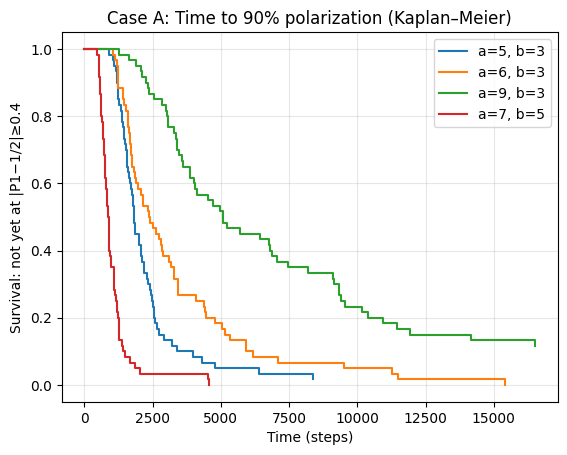

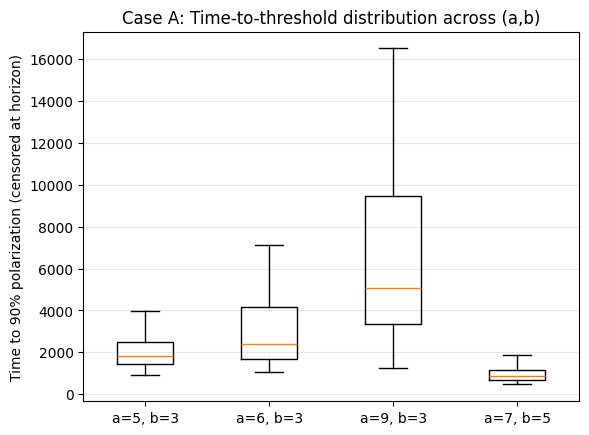

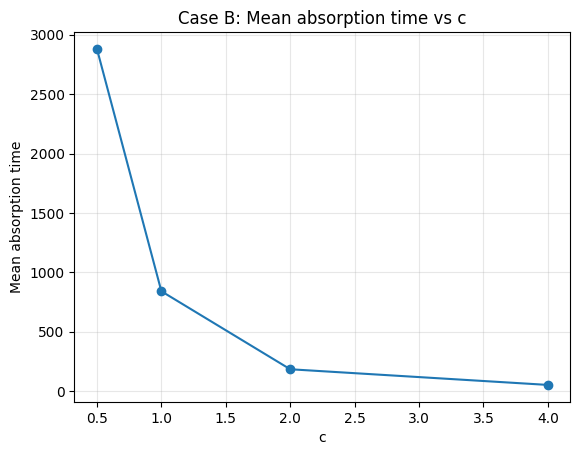

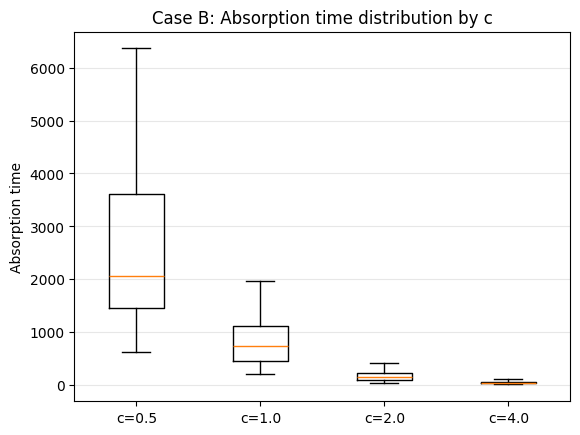

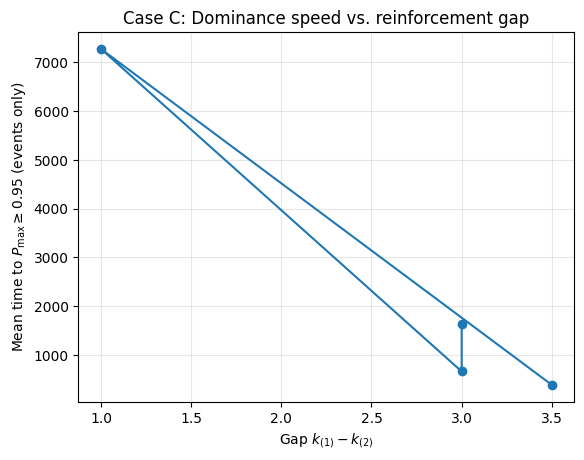

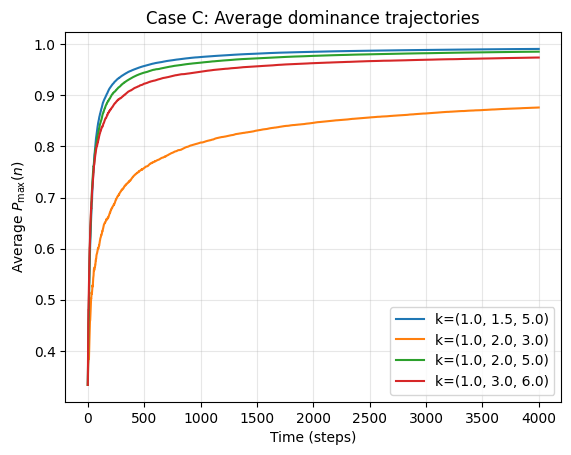

Done. Outputs saved under: polya_urn_verification_part22
Figures:
  polya_urn_verification_part22/figs/part2_case1_km_polarization.png 
  polya_urn_verification_part22/figs/part2_case1_box_times.png 
  polya_urn_verification_part22/figs/part2_case2_mean_tau_vs_c.png 
  polya_urn_verification_part22/figs/part2_case2_box_tau_by_c.png 
  polya_urn_verification_part22/figs/part2_case3_mean_time_vs_gap.png 
  polya_urn_verification_part22/figs/part2_case3_avg_Pmax_trajectories.png
CSVs:
  polya_urn_verification_part22/csv/part2_case1_polarization_sweep.csv 
  polya_urn_verification_part22/csv/part2_case1_summary.csv 
  polya_urn_verification_part22/csv/part2_case2_absorption_times.csv 
  polya_urn_verification_part22/csv/part2_case2_summary.csv 
  polya_urn_verification_part22/csv/part2_case3_time_to_95.csv 
  polya_urn_verification_part22/csv/part2_case3_summary.csv
LaTeX tables:
  polya_urn_verification_part22/tex/part2_case1_summary.tex 
  polya_urn_verification_part22/tex/part2_case2_su

In [8]:
# Simulation Part 2 (Colab-ready): Parameter sweeps & diagnostics for generalized Pólya urns
# - Row convention: when color i is drawn, X += R[i, :]
# - Tenable: absorb BEFORE a negative count would occur
# - A) Two-color: time to |P1 - 1/2| >= 0.4 (≈ 90% polarization) across (a,b)
# - B) Skew-symmetric 3-color: absorption time vs c
# - C) Diagonal reinforcement: time to P_max >= 0.95 vs reinforcement gap
#
# Outputs to: polya_urn_verification_part2/{figs,csv,tex}
# You can safely re-run; files are overwritten.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# -----------------------
# Reproducibility & I/O
# -----------------------
rng = np.random.default_rng(314159)

base_dir = "polya_urn_verification_part22"
fig_dir  = os.path.join(base_dir, "figs")
csv_dir  = os.path.join(base_dir, "csv")
tex_dir  = os.path.join(base_dir, "tex")
for d in (fig_dir, csv_dir, tex_dir):
    os.makedirs(d, exist_ok=True)

# -----------------------
# Core simulator
# -----------------------
def simulate_urn(R, X0, n_steps=20000, tenable=True, record_every=1, stop_on_threshold=None):
    """
    Row convention: when color i is drawn, X += R[i,:].
    Draw probs: X_i / S where S = sum(X).
    tenable=True: if X + delta would make any coordinate negative, ABSORB (stop) at current X.
    stop_on_threshold: callable(X)->bool; if True (checked pre-draw), stop and return.
    Returns:
      dict with X_traj (T,d), P_traj (T,d), tau_absorb (int), tau_thresh (int|None)
    """
    R = np.asarray(R, dtype=float)
    X = np.asarray(X0, dtype=float).copy()
    d = len(X)
    S0 = X.sum()

    X_list = [X.copy()]
    P_list = [X / S0 if S0 > 0 else np.zeros_like(X)]

    tau_absorb = None
    tau_thresh = None

    for t in range(n_steps):
        S = X.sum()
        if S <= 0:
            tau_absorb = t if tau_absorb is None else tau_absorb
            break

        # Threshold check on current state (pre-draw)
        if stop_on_threshold is not None and tau_thresh is None:
            if stop_on_threshold(X):
                tau_thresh = t
                break

        p = X / S
        i = rng.choice(d, p=p)
        delta = R[i, :]

        if tenable and np.any(X + delta < 0):
            tau_absorb = t
            break

        X = X + delta

        if (t + 1) % record_every == 0:
            S_new = X.sum()
            P = X / S_new if S_new > 0 else np.zeros_like(X)
            X_list.append(X.copy())
            P_list.append(P)

    T = len(X_list)
    return {
        "X_traj":    np.vstack(X_list),
        "P_traj":    np.vstack(P_list),
        "tau_absorb": tau_absorb if tau_absorb is not None else T - 1,
        "tau_thresh": tau_thresh
    }

# -----------------------
# Kaplan–Meier utility
# -----------------------
def km_survival(times, events):
    """
    Right-censored KM (step function).
    times: integer times
    events: 1 if event, 0 if censored
    Returns (t_vals, S_vals) for a step plot (right-continuous).
    """
    df = pd.DataFrame({"t": times, "e": events}).sort_values("t")
    unique_t = np.unique(df["t"].values)

    at_risk = len(df)
    S = 1.0
    t_points = [0]
    S_points = [1.0]

    for t in unique_t:
        d_t = int(((df["t"] == t) & (df["e"] == 1)).sum())
        n_t = int((df["t"] == t).sum())
        if at_risk > 0:
            if d_t > 0:
                S *= (1 - d_t / at_risk)
                t_points.append(t)
                S_points.append(S)
            at_risk -= n_t
    return np.array(t_points), np.array(S_points)

# Robust boxplot labels across Matplotlib versions (3.9+ uses tick_labels)
def boxplot_with_labels(ax, data, labels, **kwargs):
    try:
        return ax.boxplot(data, tick_labels=labels, **kwargs)  # New API
    except TypeError:
        return ax.boxplot(data, labels=labels, **kwargs)       # Fallback

# -------------
# A) Two-color
# -------------
configs_case1 = [
    {"a": 5, "b": 3},
    {"a": 6, "b": 3},
    {"a": 9, "b": 3},
    {"a": 7, "b": 5},
]
X0_two         = np.array([1000.0, 1000.0])
n_reps_case1   = 60      # adjust up/down for heavier/lighter
horizon_case1  = 20000

def thresh_case1(X):
    S = X.sum()
    p1 = X[0] / S if S > 0 else 0.5
    return abs(p1 - 0.5) >= 0.4  # i.e., P1 >= 0.9 or <= 0.1

records_case1 = []
km_data_case1 = {}

for cfg in configs_case1:
    a, b = cfg["a"], cfg["b"]
    R = np.array([[ a, -b],
                  [-b,  a]], dtype=float)
    label = f"a={a}, b={b}"
    times, events = [], []
    for r in range(n_reps_case1):
        out = simulate_urn(R, X0_two, n_steps=horizon_case1, tenable=True, stop_on_threshold=thresh_case1)
        t = out["tau_thresh"] if out["tau_thresh"] is not None else horizon_case1
        event = 1 if out["tau_thresh"] is not None else 0
        records_case1.append({"label": label, "rep": r, "time_to_90pct": t, "event": event})
        times.append(t); events.append(event)
    km_data_case1[label] = (np.array(times), np.array(events))

df_case1 = pd.DataFrame.from_records(records_case1)
df_case1_path = os.path.join(csv_dir, "part2_case1_polarization_sweep.csv")
df_case1.to_csv(df_case1_path, index=False)

# KM curves
plt.figure()
for cfg in configs_case1:
    label = f"a={cfg['a']}, b={cfg['b']}"
    t_vals, S_vals = km_survival(*km_data_case1[label])
    plt.step(t_vals, S_vals, where="post", label=label)
plt.xlabel("Time (steps)")
plt.ylabel("Survival: not yet at |P1−1/2|≥0.4")
plt.title("Case A: Time to 90% polarization (Kaplan–Meier)")
plt.legend()
plt.grid(True, alpha=0.3)
figA1 = os.path.join(fig_dir, "part2_case1_km_polarization.png")
plt.savefig(figA1, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

# Boxplots (censored at horizon)
plt.figure()
ax = plt.gca()
labelsA = [f"a={c['a']}, b={c['b']}" for c in configs_case1]
dataA   = [df_case1[df_case1["label"]==lab]["time_to_90pct"].values for lab in labelsA]
boxplot_with_labels(ax, dataA, labelsA, showfliers=False)
plt.ylabel("Time to 90% polarization (censored at horizon)")
plt.title("Case A: Time-to-threshold distribution across (a,b)")
plt.grid(True, axis="y", alpha=0.3)
figA2 = os.path.join(fig_dir, "part2_case1_box_times.png")
plt.savefig(figA2, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

# Summary table (median & event rate)
summary_rows_A = []
for lab in labelsA:
    sub  = df_case1[df_case1["label"]==lab]
    med  = float(np.median(sub["time_to_90pct"].values))
    rate = float(sub["event"].mean())
    summary_rows_A.append({"Config": lab, "Median time": round(med,2), "Pr(event)": round(rate,2)})
df_case1_summary = pd.DataFrame(summary_rows_A)
df_case1_summary_path = os.path.join(csv_dir, "part2_case1_summary.csv")
df_case1_summary.to_csv(df_case1_summary_path, index=False)

with open(os.path.join(tex_dir, "part2_case1_summary.tex"), "w") as f:
    f.write("\\begin{table}[t]\n\\centering\n")
    f.write("\\caption{Case A (two colors): time to reach $|P_1-1/2|\\geq 0.4$ (60 reps).}\n")
    f.write("\\label{tab:part2-case1}\n")
    f.write("\\begin{tabular}{lcc}\n\\toprule\nConfig & Median time & $\\Pr(\\text{event})$ \\\\\n\\midrule\n")
    for row in summary_rows_A:
        f.write(f"{row['Config']} & {row['Median time']} & {row['Pr(event)']} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n\\end{table}\n")

# ----------------------------
# B) Skew-symmetric 3-color
# ----------------------------
cs = [0.5, 1.0, 2.0, 4.0]
X0_three        = np.array([30.0, 30.0, 30.0])
n_reps_case2    = 120
horizon_case2   = 20000

records_case2 = []
for c in cs:
    R = np.array([[ 0,  c, -c],
                  [-c,  0,  c],
                  [ c, -c,  0]], dtype=float)
    for r in range(n_reps_case2):
        out = simulate_urn(R, X0_three, n_steps=horizon_case2, tenable=True, stop_on_threshold=None)
        records_case2.append({"c": c, "rep": r, "tau_absorb": out["tau_absorb"]})

df_case2 = pd.DataFrame.from_records(records_case2)
df_case2_path = os.path.join(csv_dir, "part2_case2_absorption_times.csv")
df_case2.to_csv(df_case2_path, index=False)

meansB = df_case2.groupby("c", as_index=False)["tau_absorb"].mean()

plt.figure()
plt.plot(meansB["c"].values, meansB["tau_absorb"].values, marker="o")
plt.xlabel("c")
plt.ylabel("Mean absorption time")
plt.title("Case B: Mean absorption time vs c")
plt.grid(True, alpha=0.3)
figB1 = os.path.join(fig_dir, "part2_case2_mean_tau_vs_c.png")
plt.savefig(figB1, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

plt.figure()
ax = plt.gca()
dataB   = [df_case2[df_case2["c"]==c]["tau_absorb"].values for c in cs]
labelsB = [f"c={c}" for c in cs]
boxplot_with_labels(ax, dataB, labelsB, showfliers=False)
plt.ylabel("Absorption time")
plt.title("Case B: Absorption time distribution by c")
plt.grid(True, axis="y", alpha=0.3)
figB2 = os.path.join(fig_dir, "part2_case2_box_tau_by_c.png")
plt.savefig(figB2, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

summary_rows_B = []
for c in cs:
    sub = df_case2[df_case2["c"]==c]["tau_absorb"].values
    summary_rows_B.append({
        "c": c,
        "Mean":   round(float(np.mean(sub)),2),
        "Median": round(float(np.median(sub)),2),
        "Q1":     round(float(np.quantile(sub,0.25)),2),
        "Q3":     round(float(np.quantile(sub,0.75)),2)
    })
df_case2_summary = pd.DataFrame(summary_rows_B)
df_case2_summary_path = os.path.join(csv_dir, "part2_case2_summary.csv")
df_case2_summary.to_csv(df_case2_summary_path, index=False)

with open(os.path.join(tex_dir, "part2_case2_summary.tex"), "w") as f:
    f.write("\\begin{table}[t]\n\\centering\n")
    f.write("\\caption{Case B (skew--symmetric): absorption time by $c$ (120 reps).}\n")
    f.write("\\label{tab:part2-case2}\n")
    f.write("\\begin{tabular}{lcccc}\n\\toprule\n$c$ & Mean $\\tau$ & Median $\\tau$ & $Q_{0.25}$ & $Q_{0.75}$ \\\\\n\\midrule\n")
    for row in summary_rows_B:
        f.write(f"{row['c']} & {row['Mean']} & {row['Median']} & {row['Q1']} & {row['Q3']} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n\\end{table}\n")

# -----------------------------------------
# C) Diagonal reinforcement (dominance)
# -----------------------------------------
diag_configs = [
    {"k": (1.0, 2.0, 3.0)},
    {"k": (1.0, 2.0, 5.0)},
    {"k": (1.0, 3.0, 6.0)},
    {"k": (1.0, 1.5, 5.0)},
]
X0_diag        = np.array([10.0, 10.0, 10.0])
n_reps_case3   = 60
horizon_case3  = 15000
p_thresh       = 0.95

def time_to_threshold_diag(k_tuple, X0, reps, horizon, p_thresh=0.95):
    k = np.array(k_tuple, dtype=float)
    R = np.diag(k)
    idx_max = int(np.argmax(k))
    label = f"k={tuple(map(float,k_tuple))}"  # store as a string label
    rows = []
    for r in range(reps):
        def thresh(X):
            S = X.sum()
            P = X / S if S > 0 else np.zeros_like(X)
            return P[idx_max] >= p_thresh
        out = simulate_urn(R, X0, n_steps=horizon, tenable=True, stop_on_threshold=thresh)
        t = out["tau_thresh"] if out["tau_thresh"] is not None else horizon
        event = 1 if out["tau_thresh"] is not None else 0
        gap = float(k[idx_max] - np.partition(k, -2)[-2])  # k_(1) - k_(2)
        rows.append({"label": label, "rep": r, "gap": gap,
                     "time_to_95": t, "event": event, "idx_max": idx_max, "k_tuple": label})
    return rows

records_case3 = []
for cfg in diag_configs:
    records_case3.extend(time_to_threshold_diag(cfg["k"], X0_diag, n_reps_case3, horizon_case3, p_thresh=p_thresh))

df_case3 = pd.DataFrame.from_records(records_case3)
df_case3_path = os.path.join(csv_dir, "part2_case3_time_to_95.csv")
df_case3.to_csv(df_case3_path, index=False)

labelsC = sorted(df_case3["label"].unique())
gaps     = []
means_ev = []
for lab in labelsC:
    sub = df_case3[df_case3["label"]==lab]
    gaps.append(float(sub["gap"].iloc[0]))
    ev_times  = sub[sub["event"]==1]["time_to_95"].values
    means_ev.append(float(ev_times.mean()) if len(ev_times)>0 else horizon_case3)

plt.figure()
plt.plot(gaps, means_ev, marker="o")
plt.xlabel("Gap $k_{(1)}-k_{(2)}$")
plt.ylabel("Mean time to $P_{\\max}\\geq 0.95$ (events only)")
plt.title("Case C: Dominance speed vs. reinforcement gap")
plt.grid(True, alpha=0.3)
figC1 = os.path.join(fig_dir, "part2_case3_mean_time_vs_gap.png")
plt.savefig(figC1, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

# Average P_max trajectories (lighter: avg 20 reps up to 4000 steps)
plt.figure()
avg_steps = 4000
m_avg     = 20
for lab in labelsC:
    ktuple = tuple(map(float, literal_eval(lab.split("=",1)[1])))  # safe parse
    k      = np.array(ktuple, dtype=float)
    R      = np.diag(k)
    idx_max = int(np.argmax(k))
    Pmax_accum = np.zeros(avg_steps+1, dtype=float)
    for r in range(m_avg):
        out = simulate_urn(R, X0_diag, n_steps=avg_steps, tenable=True)
        Pmax_accum += out["P_traj"][:avg_steps+1, idx_max]
    Pmax_mean = Pmax_accum / m_avg
    plt.plot(np.arange(avg_steps+1), Pmax_mean, label=lab)
plt.xlabel("Time (steps)")
plt.ylabel("Average $P_{\\max}(n)$")
plt.title("Case C: Average dominance trajectories")
plt.legend()
plt.grid(True, alpha=0.3)
figC2 = os.path.join(fig_dir, "part2_case3_avg_Pmax_trajectories.png")
plt.savefig(figC2, bbox_inches="tight", dpi=200)
plt.show()
plt.close()

# Summary table for Case C
summary_rows_C = []
for lab in labelsC:
    sub = df_case3[df_case3["label"]==lab]
    gap = float(sub["gap"].iloc[0])
    event_rate = float(sub["event"].mean())
    med_time   = float(np.median(sub["time_to_95"].values))
    summary_rows_C.append({
        "Config": lab, "Gap": round(gap,2),
        "Event rate": round(event_rate,2),
        "Median time (cens.)": round(med_time,2)
    })
df_case3_summary = pd.DataFrame(summary_rows_C)
df_case3_summary_path = os.path.join(csv_dir, "part2_case3_summary.csv")
df_case3_summary.to_csv(df_case3_summary_path, index=False)

with open(os.path.join(tex_dir, "part2_case3_summary.tex"), "w") as f:
    f.write("\\begin{table}[t]\n\\centering\n")
    f.write("\\caption{Case C (diagonal): time to $P_{\\max}\\geq 0.95$ vs. reinforcement gap (60 reps).}\n")
    f.write("\\label{tab:part2-case3}\n")
    f.write("\\begin{tabular}{lccc}\n\\toprule\nConfig & Gap & Event rate & Median time (cens.) \\\\\n\\midrule\n")
    for row in summary_rows_C:
        f.write(f"{row['Config']} & {row['Gap']} & {row['Event rate']} & {row['Median time (cens.)']} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n\\end{table}\n")

print("Done. Outputs saved under:", base_dir)
print("Figures:\n ", figA1, "\n ", figA2, "\n ", figB1, "\n ", figB2, "\n ", figC1, "\n ", figC2)
print("CSVs:\n ", df_case1_path, "\n ", df_case1_summary_path, "\n ", df_case2_path, "\n ", df_case2_summary_path, "\n ", df_case3_path, "\n ", df_case3_summary_path)
print("LaTeX tables:\n ", os.path.join(tex_dir, "part2_case1_summary.tex"),
      "\n ", os.path.join(tex_dir, "part2_case2_summary.tex"),
      "\n ", os.path.join(tex_dir, "part2_case3_summary.tex"))
